# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.
Шаги для выбора локации обычно такие:
- В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
- Строят модель для предсказания объёма запасов в новых скважинах;
- Выбирают скважины с самыми высокими оценками значений;
- Определяют регион с максимальной суммарной прибылью отобранных скважин.

- Вам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. Постройте модель для определения региона, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой Bootstrap.

### Описание данных
Данные геологоразведки трёх регионов находятся в файлах:
- `/datasets/geo_data_0.csv`;
- `/datasets/geo_data_1.csv`;
- `/datasets/geo_data_2.csv`;
- `id` — уникальный идентификатор скважины;
- `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
- `product` — объём запасов в скважине (тыс. баррелей).

**Условия задачи:**
- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

## Постановка задачи
### [Шаг 1. Знакомство с данными, их изучение и предобработка](#section1)
Загрузить и подготовить данные. Пояснить порядок действий.

### [Шаг 2. Обучение и проверка модели для каждого региона:](#section2)
2.1. Разбить данные на обучающую и валидационную выборки в соотношении 75:25.
2.2. Обучить модель и сделать предсказания на валидационной выборке.
2.3. Сохранить предсказания и правильные ответы на валидационной выборке.
2.4. Напечать на экране средний запас предсказанного сырья и RMSE модели.
2.5. Проанализировать результаты.

### [Шаг 3. Подготовка к расчёту прибыли:](#section3)
3.1. Все ключевые значения для расчётов сохранить в отдельных переменных.
3.2. Рассчитать достаточный объём сырья для безубыточной разработки новой скважины. Сравнить полученный объём сырья со средним запасом в каждом регионе.
3.3. Написать выводы по этапу подготовки расчёта прибыли.

### [Шаг 4. Создание функции для расчёта прибыли по выбранным скважинам и предсказаниям модели:](#section4)
4.1. Выбрать скважины с максимальными значениями предсказаний.
4.2. Просуммировать целевое значение объёма сырья, соответствующее этим предсказаниям.
4.3. Рассчитать прибыль для полученного объёма сырья.

### [Шаг 5. Расчет рисков и прибылей для каждого региона:](#section5)
5.1. Применить технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
5.2. Найти среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
5.3. Написать выводы: предложить регион для разработки скважин и обосновать выбор.

### [Шаг 6. Общий вывод](#section6)


# Решение задачи
## Шаг 1. Знакомство с данными, их изучение и предобработка <a class="anchor" id="section1"></a>

Импортируем необходимые библиотеки для дальнейшей работы.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as st
import scipy.stats as sst

from sklearn import preprocessing as sp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import warnings

warnings.filterwarnings('ignore')

# Здесь же зафиксируем псевдослучайность
random_val = np.random.RandomState(42)

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

Загрузим данные.

In [2]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

Создадим функцию для получения общей информации о наборе данных каждого региона.

In [3]:
def research_info(data):
    print('Размеры таблицы: {}'.format(data.shape))
    print('Дубликатов: {}'.format(data.isna().sum().sum()))
    print('Пропусков: {}'.format(data.duplicated().sum()))
    display(data.describe())
    print('Распределение признаков:')
    data[['f0', 'f1', 'f2']].boxplot()
    plt.show()

Регион 0
Размеры таблицы: (100000, 5)
Дубликатов: 0
Пропусков: 0


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


Распределение признаков:


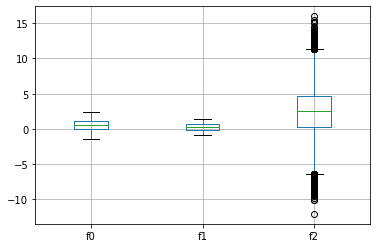

In [4]:
print('Регион 0')
research_info(geo_data_0)

Регион 1
Размеры таблицы: (100000, 5)
Дубликатов: 0
Пропусков: 0


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


Распределение признаков:


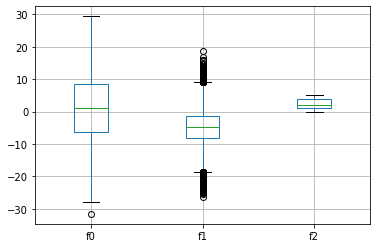

In [5]:
print('Регион 1')
research_info(geo_data_1)

Регион 2
Размеры таблицы: (100000, 5)
Дубликатов: 0
Пропусков: 0


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Распределение признаков:


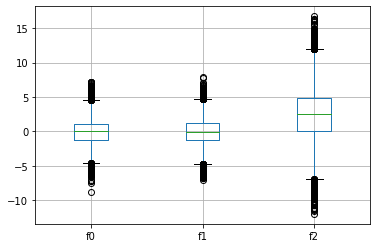

In [6]:
print('Регион 2')
research_info(geo_data_2)

In [7]:
for idx, geo_data in enumerate((geo_data_0, geo_data_1, geo_data_2)):
    print('Уникальные ли значения id в датасете региона {}: {}'.format(
        idx,
        geo_data['id'].unique().shape[0] == geo_data.shape[0],
    ))

Уникальные ли значения id в датасете региона 0: False
Уникальные ли значения id в датасете региона 1: False
Уникальные ли значения id в датасете региона 2: False


*Итоги ознакомительной работы:*
1. Ящики с усами показывают, что в некоторых столбцах есть данные с выбросами. Такие выбросы лучше удалить, чтобы не портилось качество обучения.
2. Столбец `id` не несет в себе важной для обучения информации и его смело можно удалить.

In [8]:
def remove_tails(data, column):
    del_index = []
    q25 = np.array(data[column].quantile(0.25))
    q75 = np.array(data[column].quantile(0.75))
    min_part = q25 - 1.5 * (q75 - q25)
    max_part = q75 + 1.5 * (q75 - q25)
    for index_value, value in zip(data[column].index, data[column]):
        if value <= min_part or max_part <= value:
            del_index.append(index_value)
    return del_index

Удалим так же столбец `id`.

In [10]:
for geo_data in (geo_data_0, geo_data_1, geo_data_2):
    geo_data.drop('id', axis=1, inplace=True)

Проверим есть ли корреляция между данными.

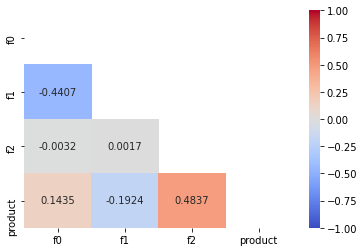

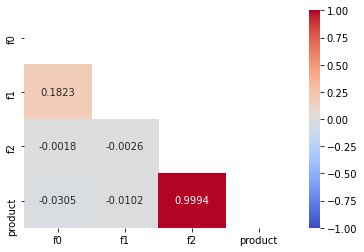

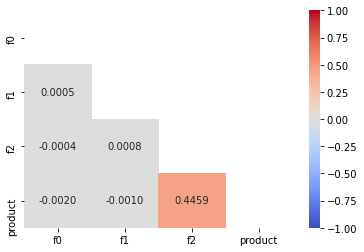

In [11]:
for geo_data in (geo_data_0, geo_data_1, geo_data_2):
    mask = np.triu(np.ones_like(geo_data.corr(), dtype=np.bool))
    sns.heatmap(geo_data.corr(), mask=mask, annot=True, fmt='.4f',
                vmin=-1, vmax=1, cmap='coolwarm')
    plt.show()

*Итог предобработки:*
1. Для региона 0 признаки `f0` и `f1` согласно шкале Чеддока средне-отрицательно коррелируют между собой, `f2` и `product` - средне-положительно, по остальным парам корреляция очень слабая.
2. Для региона 1 признаки `f2` и `product` коррелируют между собой очень высоко, по остальным парам корреляция очень слабая.
2. Для региона 2 признаки `f2` и `product` коррелируют между собой средне-положительно, по остальным парам корреляция очень слабая.

Если в случае с данными региона 1 все достаточно понятно, там очень высокая корреляция и признак `f2` следует удалить, то вот в случае с остальными стоит опираться на результат, который будет получен на моделях.

Следовательно, необходимо подготовить 3 выборки:
- для региона 0 сохранив все столбцы;
- для региона 1 удалив столбец `f2`;
- для региона 1 сохранив все столбцы;
- для региона 2 сохранив все столбцы.


In [12]:
geo_data_1_out_f2 = geo_data_1.drop(['f2'], axis=1)

**Итог первичного анализа:**
- данные проверены на отсутствие пропусков;
- дубликаты в данных отсутствуют;
- данные очищены от выбросов;
- учтены коррелирующие признаки.

Данные готовы к обучению.

На следующем этапе необходимо:
1. провести разделение на обучающую и валидационную выборки;
2. нормализовать данные для каждой выборки.

## Шаг 2. Обучение и проверка модели для каждого региона <a class="anchor" id="section2"></a>


Создадим функцию, которая разделит данные каждого региона на обучающую и валидационную выборки.

In [13]:
def split_data(data):
    features_train_data, features_valid_data, target_train_data, target_valid_data = train_test_split(
        data.drop(['product'], axis=1), data['product'], test_size=0.25, random_state=random_val)
    print('Размер обучающей выборки', features_train_data.shape[0])
    print('Размер валидационной выборки', features_valid_data.shape[0])
    return features_train_data, features_valid_data, target_train_data, target_valid_data

In [14]:
geo_0_features_train, geo_0_features_valid, geo_0_target_train, geo_0_target_valid = split_data(geo_data_0)

Размер обучающей выборки 75000
Размер валидационной выборки 25000


Проведем дополнительно исследование для данных без учета работы с коррелирующими признаками.

In [15]:
geo_1_features_train, geo_1_features_valid, geo_1_target_train, geo_1_target_valid = split_data(geo_data_1_out_f2)

Размер обучающей выборки 75000
Размер валидационной выборки 25000


In [17]:
geo_1_features_train_dirt, geo_1_features_valid_dirt, geo_1_target_train_dirt, geo_1_target_valid_dirt = split_data(geo_data_1)

Размер обучающей выборки 75000
Размер валидационной выборки 25000


In [16]:
geo_2_features_train, geo_2_features_valid, geo_2_target_train, geo_2_target_valid = split_data(geo_data_2)

Размер обучающей выборки 75000
Размер валидационной выборки 25000


Создадим функцию, которая будет выполнять следующий набор действий:
- получает на вход набор данных (созданные ранее обучающие и валидационные выборки);
- нормализует признаки на обучающей и валидационной выборках;
- возвращает таблицу сравнений реального и предсказанного объемов нефти в скважинах, RMSE, средний предсказанный запас сырья в регионе, суммарный предсказанный запас.

In [18]:
lr = LinearRegression(normalize=False)


def oil_predict(features_train, features_valid, target_train, target_valid):
    scaler = sp.MinMaxScaler()
    features_train = scaler.fit_transform(features_train)
    features_valid = scaler.transform(features_valid)

    lr.fit(features_train, target_train)

    predicted_target = lr.predict(features_valid)
    data = {'real_product': target_valid,
            'predicted_product': predicted_target,
            }
    data_frame = pd.DataFrame(data, columns=['real_product', 'predicted_product'])
    rmse = mean_squared_error(target_valid, predicted_target) ** 0.5
    mean = data_frame['predicted_product'].mean()
    oil_sum = data_frame['predicted_product'].sum()
    return data_frame, rmse, mean, oil_sum

In [19]:
def oil_info(data_frame, rmse, mean, oil_sum):
    print(data_frame.sample(n=3))
    print('RMSE - {:.3f}'.format(rmse))
    print('Средний запас сырья - {:.3f}'.format(mean))
    print('Суммарный предсказанный запас в регионе - {:.3f}'.format(oil_sum))
    print('Суммарный реальный запас в регионе - {:.3f}'.format(data_frame['real_product'].sum()))
    print('Абсолютная разница реальных и предсказанных суммарных запасов - {:.3f}'.format(
        abs(data_frame['real_product'].sum() - oil_sum)))
    return

In [20]:
geo_0_predicted, geo_0_rmse, geo_0_predicted_mean, geo_0_predicted_sum = oil_predict(geo_0_features_train,
                                                                                     geo_0_features_valid,
                                                                                     geo_0_target_train,
                                                                                     geo_0_target_valid)
print('Регион 0')
oil_info(geo_0_predicted, geo_0_rmse, geo_0_predicted_mean, geo_0_predicted_sum)

Регион 0
       real_product  predicted_product
80635      9.270928          50.729988
7665     112.478330         106.976788
62311    112.859826         123.632357
RMSE - 37.757
Средний запас сырья - 92.399
Суммарный предсказанный запас в регионе - 2309969.998
Суммарный реальный запас в регионе - 2308148.909
Абсолютная разница реальных и предсказанных суммарных запасов - 1821.088


In [21]:
geo_1_predicted, geo_1_rmse, geo_1_predicted_mean, geo_1_predicted_sum = oil_predict(geo_1_features_train,
                                                                                     geo_1_features_valid,
                                                                                     geo_1_target_train,
                                                                                     geo_1_target_valid)
print('Регион 1')
oil_info(geo_1_predicted, geo_1_rmse, geo_1_predicted_mean, geo_1_predicted_sum)

Регион 1
       real_product  predicted_product
62526     26.953261          66.905616
5588      84.038886          70.877342
90237     30.132364          70.390411
RMSE - 45.920
Средний запас сырья - 68.893
Суммарный предсказанный запас в регионе - 1722335.803
Суммарный реальный запас в регионе - 1714992.183
Абсолютная разница реальных и предсказанных суммарных запасов - 7343.619


In [23]:
geo_1_predicted_dirt, geo_1_rmse_dirt, geo_1_predicted_mean_dirt, geo_1_predicted_sum_dirt = oil_predict(geo_1_features_train_dirt,
                                                                                                         geo_1_features_valid_dirt,
                                                                                                         geo_1_target_train_dirt,
                                                                                                         geo_1_target_valid_dirt)
print('Регион 1 (с сильно-коррелирующими данными)')
oil_info(geo_1_predicted_dirt, geo_1_rmse_dirt, geo_1_predicted_mean_dirt, geo_1_predicted_sum_dirt)

Регион 1 (с сильно-коррелирующими данными)
       real_product  predicted_product
17795    110.992147         110.730647
1918      84.038886          83.268672
57651    134.766305         134.565815
RMSE - 0.893
Средний запас сырья - 68.569
Суммарный предсказанный запас в регионе - 1714237.083
Суммарный реальный запас в регионе - 1714106.319
Абсолютная разница реальных и предсказанных суммарных запасов - 130.764


In [22]:
geo_2_predicted, geo_2_rmse, geo_2_predicted_mean, geo_2_predicted_sum = oil_predict(geo_2_features_train,
                                                                                     geo_2_features_valid,
                                                                                     geo_2_target_train,
                                                                                     geo_2_target_valid)
print('Регион 2')
oil_info(geo_2_predicted, geo_2_rmse, geo_2_predicted_mean, geo_2_predicted_sum)

Регион 2
       real_product  predicted_product
85077     74.427303          84.396192
45215    157.119583         102.219135
73038     45.335958          67.597622
RMSE - 40.237
Средний запас сырья - 95.092
Суммарный предсказанный запас в регионе - 2377307.585
Суммарный реальный запас в регионе - 2375880.468
Абсолютная разница реальных и предсказанных суммарных запасов - 1427.117


**Итог:**

Данные предсказаний о количестве нефти по сумме примерно совпадают по сумме с предсказанными значениями. Лучше всего модель предсказала запасы в нулевом регионе 0 (RMSE - 37.815), далее в регионе 2 и регионе 1 соответственно.
1. Регион 0:
- Ошибка в нулевом регионе самая маленькая, но по среднему объему запасов регион на втором месте
2. Регион 1:
- Проигрывает другим регионам и по показателю средней ошибки и по среднему объему запасов
3. Регион 1 (с сильно-коррелирующими данными)
- Проигрывает другим регионам по среднему объему запасов, но средняя ошибка очень мала. *Модель с большой вероятностью переобучилась*
4. Регион 2:
- Самый большой средний объем запасов, но по ошибке регион на втором месте


## Шаг 3. Подготовка к расчёту прибыли <a class="anchor" id="section3"></a>

Сохраним все ключевые значения для расчетов согласно условиям задачи в переменные.

In [24]:
# Количество исследуемых точек при разведке
RESEARCH_POINTS = 500
# Количество лучших исследуемых точек
BEST_RESEARCH_POINTS = 200
# Бюджет на разработку скважин в регионе
BUDGET = 1 * 1e10
# Цена за 1000 баррелей сырья
PRODUCT_PRICE = 4.5 * 1e5
# Максимальная вероятность убытков
MAX_LOSS = 2.5 * 1e-2
# Количество выборок для bootstrap
BOOTSTRAP_SAMPLES = 1000
# Доверительный интервал
CONF_INTERVAL = 9.5 * 1e-1

In [25]:
min_region_product = BUDGET / PRODUCT_PRICE
min_product = min_region_product / BEST_RESEARCH_POINTS
print('Минимальный достаточный объем добычи в регионе для безубыточной разработки {:.2f} тыс. баррелей'
      .format(min_region_product))
print('Средний минимальный объем добычи в скважине для безубыточной разработки {:.2f} тыс. баррелей'
      .format(min_product))

Минимальный достаточный объем добычи в регионе для безубыточной разработки 22222.22 тыс. баррелей
Средний минимальный объем добычи в скважине для безубыточной разработки 111.11 тыс. баррелей


In [26]:
def oil_hist(column, bins=250):
    plt.figure()
    plt.hist(column, bins=bins)
    m = st.mean(column)
    sd = st.stdev(column)

    plt.axvline(m, color='k', linestyle='dashed')
    plt.axvline(m + sd, color='y', linestyle='dashed')
    plt.axvline(m - sd, color='y', linestyle='dashed')

    plt.xlabel('Объем нефти на скважину, тыс. барелей')
    plt.ylabel('Количество скважин')
    plt.title('Гистограмма распределения по объему скважин')
    plt.show()

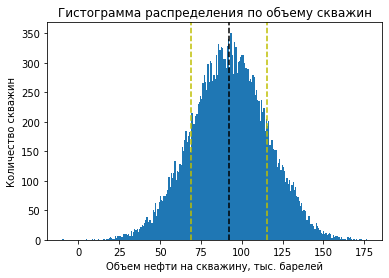

In [27]:
oil_hist(geo_0_predicted['predicted_product'])

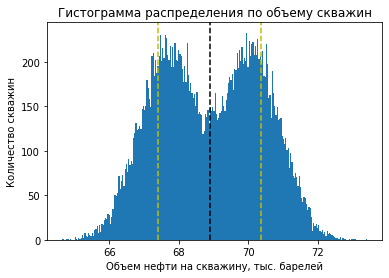

In [28]:
oil_hist(geo_1_predicted['predicted_product'])

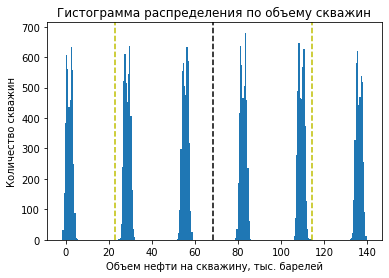

In [30]:
# Регион 1 (с сильно-коррелирующими данными)
oil_hist(geo_1_predicted_dirt['predicted_product'])

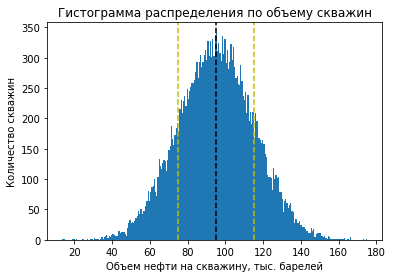

In [29]:
oil_hist(geo_2_predicted['predicted_product'])

**Итог:**
Несмотря на достаточный суммарный объем, предсказанный в каждом регионе для безубыточной разработки, во всех 3-х регионах среднее предсказанное количество сырья меньше, следовательно, не все скважины будут безубыточными.

## Шаг 4.  Создание функции для расчёта прибыли по выбранным скважинам и предсказаниям модели <a class="anchor" id="section4"></a>

In [31]:
def calculate_best_200_profit(target, predictions):
    top_predictions = predictions.sort_values(ascending=False)
    top_target = target[top_predictions.index][:BEST_RESEARCH_POINTS]
    product_volume = top_target.sum()
    profit = product_volume * PRODUCT_PRICE - BUDGET
    return profit, product_volume

In [32]:
print('Регион 0')
geo_0_profit, geo_0_product_volume = calculate_best_200_profit(geo_0_target_valid,
                                                               geo_0_predicted['predicted_product'])
print('Прибыль (млн. руб): {:.2f}'.format(geo_0_profit / 1e6))
print('Суммарный объем сырья (тыс. баррелей): {:.2f}'.format(geo_0_product_volume))

Регион 0
Прибыль (млн. руб): 3359.14
Суммарный объем сырья (тыс. баррелей): 29686.98


In [33]:
print('Регион 1')
geo_1_profit, geo_1_product_volume = calculate_best_200_profit(geo_1_target_valid,
                                                               geo_1_predicted['predicted_product'])
print('Прибыль (млн. руб): {:.2f}'.format(geo_1_profit / 1e6))
print('Суммарный объем сырья (тыс. баррелей): {:.2f}'.format(geo_1_product_volume))

Регион 1
Прибыль (млн. руб): -4243.72
Суммарный объем сырья (тыс. баррелей): 12791.74


In [35]:
print('Регион 1 (с сильно-коррелирующими данными)')
geo_1_profit_dirt, geo_1_product_volume_dirt = calculate_best_200_profit(geo_1_target_valid_dirt,
                                                                         geo_1_predicted_dirt['predicted_product'])
print('Прибыль (млн. руб): {:.2f}'.format(geo_1_profit_dirt / 1e6))
print('Суммарный объем сырья (тыс. баррелей): {:.2f}'.format(geo_1_product_volume_dirt))

Регион 1 (с сильно-коррелирующими данными)
Прибыль (млн. руб): 2415.09
Суммарный объем сырья (тыс. баррелей): 27589.08


In [34]:
print('Регион 2')
geo_2_profit, geo_2_product_volume = calculate_best_200_profit(geo_2_target_valid,
                                                               geo_2_predicted['predicted_product'])
print('Прибыль (млн. руб): {:.2f}'.format(geo_2_profit / 1e6))
print('Суммарный объем сырья (тыс. баррелей): {:.2f}'.format(geo_2_product_volume))

Регион 2
Прибыль (млн. руб): 2584.16
Суммарный объем сырья (тыс. баррелей): 27964.79


**Итог:**
На данном шаге была создана функция, рассчитывающая прибыль для 200 лучших скважин из случайного набора 500 скважин региона.

*Важно отметить, что на данном этапе функция выбирала 200 самых лучших по залежам скважин из всего объема данных, и Регион 1 даже в таком случае показал убыточность.*

## Шаг 5. Расчет рисков и прибылей для каждого региона <a class="anchor" id="section5"></a>

In [36]:
def profit_hist(column, bins=200):
    plt.figure()
    plt.hist(column, bins=bins)
    m = st.mean(column)
    sd = st.stdev(column)

    plt.axvline(m, color='k', linestyle='dashed')
    plt.axvline(m + sd, color='y', linestyle='dashed')
    plt.axvline(m - sd, color='y', linestyle='dashed')
    plt.xlabel('Прибыль со скважины, млн руб')
    plt.ylabel('Количество скважин')
    plt.title('Гистограмма распределения прибыли')
    plt.show()

In [37]:
def bootstrap_calculate_profit(target, predictions):
    values = []
    for _ in range(BOOTSTRAP_SAMPLES):
        target_sample = target.sample(RESEARCH_POINTS, replace=True, random_state=random_val)
        predictions_sample = predictions[target_sample.index]
        profit, product_volume = calculate_best_200_profit(target_sample, predictions_sample)
        values.append(profit)
    values = pd.Series(values)
    profit_mean = values.mean() / 1e6

    conf_lower = values.quantile((1 - CONF_INTERVAL) / 2) / 1e6
    conf_upper = values.quantile((1 + CONF_INTERVAL) / 2) / 1e6

    loss_probability = (values < 0).mean()

    print('Средняя прибыль (млн. руб): {:.2f}'.format(profit_mean))
    print('95% доверительный интервал (млн. руб): ({:.2f}, {:.2f})'.format(conf_lower, conf_upper))

    if loss_probability < MAX_LOSS:
        print('Вероятность убытков равна {}, что меньше чем максимальная допустимая вероятность {}'.format(
            loss_probability, MAX_LOSS))
    else:
        print('Вероятность убытков равна {}, что больше чем максимальная допустимая вероятность {}'.format(
            loss_probability, MAX_LOSS))

    profit_hist(values)
    return profit_mean, conf_lower, conf_upper, loss_probability

In [38]:
profit_and_risks = []

Средняя прибыль (млн. руб): 447.58
95% доверительный интервал (млн. руб): (-72.91, 987.77)
Вероятность убытков равна 0.05, что больше чем максимальная допустимая вероятность 0.025


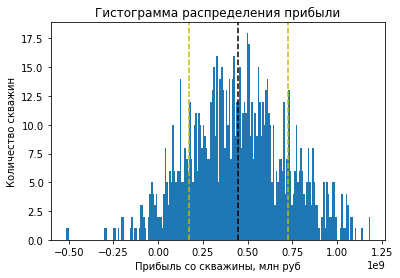

In [39]:
profit_and_risks.append(bootstrap_calculate_profit(geo_0_target_valid, geo_0_predicted['predicted_product']))

Средняя прибыль (млн. руб): -3707.29
95% доверительный интервал (млн. руб): (-4260.17, -3112.14)
Вероятность убытков равна 1.0, что больше чем максимальная допустимая вероятность 0.025


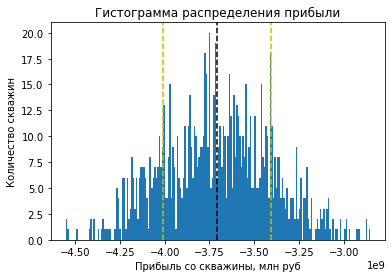

In [40]:
profit_and_risks.append(bootstrap_calculate_profit(geo_1_target_valid, geo_1_predicted['predicted_product']))

Средняя прибыль (млн. руб): 327.65
95% доверительный интервал (млн. руб): (-202.52, 874.31)
Вероятность убытков равна 0.107, что больше чем максимальная допустимая вероятность 0.025


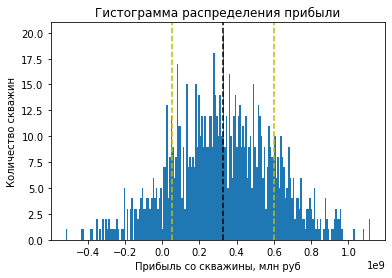

In [41]:
profit_and_risks.append(bootstrap_calculate_profit(geo_2_target_valid, geo_2_predicted['predicted_product']))

Средняя прибыль (млн. руб): 457.03
95% доверительный интервал (млн. руб): (33.95, 900.89)
Вероятность убытков равна 0.018, что меньше чем максимальная допустимая вероятность 0.025


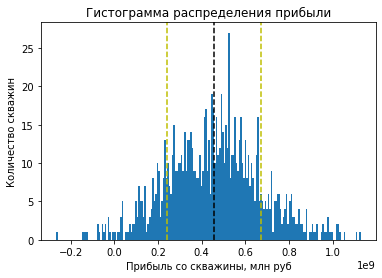

In [42]:
print('Регион 1 (с сильно-коррелирующими данными)')
profit_and_risks.append(bootstrap_calculate_profit(geo_1_target_valid_dirt, geo_1_predicted_dirt['predicted_product']))

In [43]:
profit_and_risks_df = pd.DataFrame(profit_and_risks,
                                   columns=['Средняя прибыль(млн)', 'Нижняя граница(млн)', 'Верхняя граница(млн)',
                                            'Вероятность убытков'])
profit_and_risks_df

,Средняя прибыль(млн),Нижняя граница(млн),Верхняя граница(млн),Вероятность убытков
0,447.580201,-72.913790,987.773344,0.050
1,-3707.288535,-4260.172962,-3112.141312,1.000
2,327.649098,-202.519823,874.306844,0.107
3,457.025562,33.952684,900.893958,0.018


***Итоги:***
*Лучшим регионом по прогнозам оказался Регион 0, имея и самую высокую прогнозируемую прибыль, и самую низкую вероятность убытков. Однако стоит учесть, что ни один из регионов не подходит под условия задачи, так как минимальный риск убытков в 2,5 раза больше заданных 2,5%.*
При наличии сильно-коррелируещего столбца `f2` в данных региона 1, получается, что и по средней прибыли и по рискам Регион 1 подхоит под условия задачи для безубыточной разработки.

Дополнительно: С учетом того, что возможные выбросы не были удалены, снизились возможные риски для регионов 0 и 2.


## Шаг 6. Общий вывод <a class="anchor" id="section6"></a>

В ходе проделанной работы было выполнено:
1. В рамках подготовки данных:
- проанализированы выбросы;
- проверены на пропуски и дубликаты;
- проверенны и учтены корреляции между признаками.
2. Обучены модели линейной регрессии для каждого региона. Получены и сохранены предсказания моделей для каждого региона.
3. Подготовлены данные для расчета прибыли, найдены минимальные достаточные объемы суммарно для региона и средний объем для скважины, по которым произведена дальнейшая оценка.
4. Создана функция расчета прибыли и объемов по 200 лучшим скважинам из представленного набора данных.
5. С помощью техники Bootstrap найдено распределение прибыли, средняя прибыль, 95%-й доверительный интервал и риск убытков.